# Running membership inference attacks on the Nursery data and defending using differential privacy

In this tutorial we will show how to run black-box membership attacks on both a vanilla model and models trained with differential privacy. The attacks are taken from the ART library's inference module (https://github.com/Trusted-AI/adversarial-robustness-toolbox) and the differentially private model implementation is taken fron the Differential Privacy Library (https://github.com/IBM/differential-privacy-library).

This will be demonstrated on the Nursery dataset (original dataset can be found here: https://archive.ics.uci.edu/ml/datasets/nursery).

We have already preprocessed the dataset such that all categorical features are one-hot encoded, and the data was scaled using sklearn's StandardScaler.

## Load data

In [ ]:
!pip install ai-privacy-toolkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.3 MB/s eta 0:00:00


In [ ]:
!mkdir -p ../datasets
!wget -P ../datasets https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget -P ../datasets https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget -P ../datasets https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data

--2025-02-22 12:11:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘../datasets/adult.data’

adult.data              [        <=>         ]   3.79M  1.85MB/s    in 2.0s    

2025-02-22 12:11:42 (1.85 MB/s) - ‘../datasets/adult.data’ saved [3974305]

--2025-02-22 12:11:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘../datasets/german.data’

german.data             [  <=>               ]  77.92K   388KB/s    in 0.2s    

2025-02-22 12:11:44 (38

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Ensure dataset directory exists
os.makedirs("../datasets", exist_ok=True)

# Download dataset (if not already downloaded)
nursery_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
nursery_path = "../datasets/nursery.data"
if not os.path.exists(nursery_path):
    os.system(f"wget -P ../datasets {nursery_url}")

# Define column names based on dataset documentation
columns = ["parents", "has_nurs", "form", "children", "housing", "finance", "social", "health", "class"]

# Load dataset into Pandas DataFrame
nursery_data = pd.read_csv(nursery_path, names=columns, header=None)

# Separate features and target
x = nursery_data.drop(columns=["class"])
y = nursery_data["class"]

# One-Hot Encode categorical features
categorical_features = x.columns.tolist()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_features)]
)

# Transform dataset
x_encoded = preprocessor.fit_transform(x)

# Encode target variable
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y_encoded = y.map(label_mapping).values

# Train-test split
train_size = 200
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y_encoded, test_size=0.5, stratify=y_encoded)

# Reduce to first `train_size` samples
x_train = x_train[:train_size]
y_train = y_train[:train_size]
x_test = x_test[:train_size]
y_test = y_test[:train_size]

print(f"✅ Final Train Set: {x_train.shape}, Test Set: {x_test.shape}")


✅ Final Train Set: (200, 27), Test Set: (200, 27)


## Train logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from art.estimators.classification.scikitlearn import ScikitlearnLogisticRegression

# Train Logistic Regression Model
model = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
model.fit(x_train, y_train)

# Wrap the model with ART
art_classifier = ScikitlearnLogisticRegression(model)

# Evaluate model accuracy
base_model_accuracy = model.score(x_test, y_test)

print(f'✅ Base model accuracy: {base_model_accuracy:.4f}')


✅ Base model accuracy: 0.9300


## Attack
### Black-box attack
The black-box attack basically trains an additional classifier (called the attack model) to predict the membership status of a sample. It can use as input to the learning process probabilities/logits or losses, depending on the type of model and provided configuration.
#### Train attack model

In [ ]:
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))


Unique values in y_train: [1 2 3 4]
Unique values in y_test: [1 2 3 4]


In [ ]:
# Convert y_train and y_test to zero-based category labels
num_classes = len(np.unique(y_train))  # Get number of unique classes
y_train = np.array([np.where(np.unique(y_train) == y)[0][0] for y in y_train])
y_test = np.array([np.where(np.unique(y_test) == y)[0][0] for y in y_test])

print("Updated Unique values in y_train:", np.unique(y_train))
print("Updated Unique values in y_test:", np.unique(y_test))


Updated Unique values in y_train: [0 1 2 3]
Updated Unique values in y_test: [0 1 2 3]


In [ ]:
# Define attack set sizes (50% of train & test sets)
attack_train_ratio = 0.5
attack_train_size = int(len(x_train) * attack_train_ratio)
attack_test_size = int(len(x_test) * attack_train_ratio)

# Initialize Membership Inference Attack
attack = MembershipInferenceBlackBox(art_classifier, attack_model_type="rf")

# Train the attack model with corrected labels
attack.fit(
    x_train[:attack_train_size], y_train[:attack_train_size],  # Train set
    x_test[:attack_test_size], y_test[:attack_test_size]       # Test set
)

print("✅ Membership Inference Black-Box Attack Model Trained Successfully!")


✅ Membership Inference Black-Box Attack Model Trained Successfully!


In [ ]:
#import numpy as np
#from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

# Define attack set sizes (50% of train & test sets)
# attack_train_ratio = 0.5
#attack_train_size = int(len(x_train) * attack_train_ratio)
#attack_test_size = int(len(x_test) * attack_train_ratio)

# Initialize Membership Inference Attack (Random Forest as attack model)
#attack = MembershipInferenceBlackBox(art_classifier, attack_model_type="rf")

# Train the attack model
#attack.fit(
 #   x_train[:attack_train_size], y_train[:attack_train_size],  # Train set
  #  x_test[:attack_test_size], y_test[:attack_test_size]       # Test set
#)

#print("✅ Membership Inference Black-Box Attack Model Trained Successfully!")


#### Infer membership and check accuracy

In [ ]:
# infer attacked feature
inferred_train = attack.infer(x_train[attack_train_size:], y_train[attack_train_size:])
inferred_test = attack.infer(x_test[attack_test_size:], y_test[attack_test_size:])

# check accuracy
train_acc = np.sum(inferred_train) / len(inferred_train)
test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
acc = (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))
print('attack accuracy on training data: ', train_acc)
print('attack accuracy on test data: ', test_acc)
print('overall attack accuracy: ', acc)

attack accuracy on training data:  0.48
attack accuracy on test data:  0.48
overall attack accuracy:  0.48


This means that for 54% of the data, membership status is inferred correctly (a little better than a random coin flip).

In [ ]:
def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1

    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly

    return precision, recall

# rule-based
print('precision and recall: ', calc_precision_recall(np.concatenate((inferred_train, inferred_test)),
                            np.concatenate((np.ones(len(inferred_train)), np.zeros(len(inferred_test))))))

precision and recall:  (0.48, 0.48)


## Train differentially private model

In [ ]:
!pip install diffprivlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 3.2 MB/s eta 0:00:00


In [ ]:
import diffprivlib.models as dp

dp_model = dp.LogisticRegression(epsilon=5, data_norm=5)
dp_model.fit(x_train, y_train)
# print('norm: ', np.linalg.norm(x_train) )

dp_art_model = ScikitlearnLogisticRegression(dp_model)
print('DP model accuracy: ', dp_model.score(x_test, y_test))

DP model accuracy:  0.35


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Black-box attack

In [ ]:
dp_attack = MembershipInferenceBlackBox(dp_art_model, attack_model_type='rf')

# train attack model
dp_attack.fit(x_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size],
              x_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size])

# infer
dp_inferred_train = dp_attack.infer(x_train.astype(np.float32)[attack_train_size:], y_train[attack_train_size:])
dp_inferred_test = dp_attack.infer(x_test.astype(np.float32)[attack_test_size:], y_test[attack_test_size:])

# check accuracy
dp_train_acc = np.sum(dp_inferred_train) / len(dp_inferred_train)
dp_test_acc = 1 - (np.sum(dp_inferred_test) / len(dp_inferred_test))
dp_acc = (dp_train_acc * len(dp_inferred_train) + dp_test_acc * len(dp_inferred_test)) / (len(dp_inferred_train) + len(dp_inferred_test))
print('attack accuracy on training data: ', dp_train_acc)
print('attack accuracy on test data: ', dp_test_acc)
print('overall attack accuracy: ', dp_acc)

print('precision and recall: ', calc_precision_recall(np.concatenate((dp_inferred_train, dp_inferred_test)),
                            np.concatenate((np.ones(len(dp_inferred_train)), np.zeros(len(dp_inferred_test))))))

attack accuracy on training data:  0.55
attack accuracy on test data:  0.48
overall attack accuracy:  0.515
precision and recall:  (0.514018691588785, 0.55)


The differentially private model reduces the attack accuracy, but also completely ruins the model's accuracy.
Let's see if we can find a sweet spot where both acceptable accuracy and privacy can be acheived.

In [ ]:
accuracy = []
attack_accuracy = []
epsilons = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 25.0, 75.0, 100.0, 200.0]

for eps in epsilons:
    print(eps)
    dp_clf = dp.LogisticRegression(epsilon=eps, data_norm=5)
    dp_clf.fit(x_train, y_train)
    accuracy.append(dp_clf.score(x_test, y_test))
    dp_art_classifier = ScikitlearnLogisticRegression(dp_clf)
    dp_attack = MembershipInferenceBlackBox(dp_art_classifier, attack_model_type='rf')
    dp_attack.fit(x_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size].astype(np.float32),
                  x_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
    dp_inferred_train = dp_attack.infer(x_train.astype(np.float32)[attack_train_size:], y_train.astype(np.float32)[attack_train_size:])
    dp_inferred_test = dp_attack.infer(x_test.astype(np.float32)[attack_train_size:], y_test.astype(np.float32)[attack_train_size:])
    dp_train_acc = np.sum(dp_inferred_train) / len(dp_inferred_train)
    dp_test_acc = 1 - (np.sum(dp_inferred_test) / len(dp_inferred_test))
    dp_acc = (dp_train_acc * len(dp_inferred_train) + dp_test_acc * len(dp_inferred_test)) / (len(dp_inferred_train) + len(dp_inferred_test))
    attack_accuracy.append(dp_acc)

0.01
0.1


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


0.5


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


1.0


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


5.0


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


10.0


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


25.0


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


75.0


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


100.0


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


200.0


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


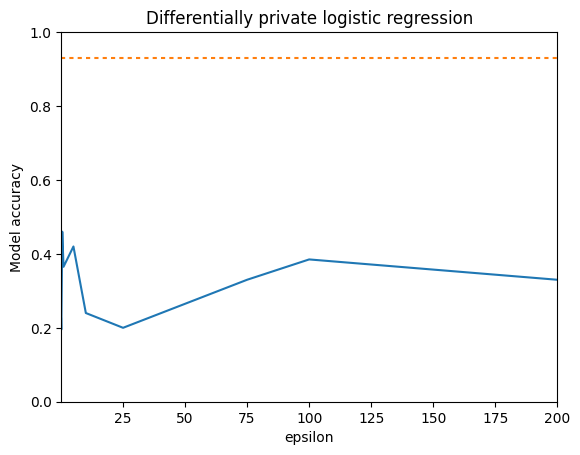

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epsilons, accuracy)
plt.plot(epsilons, np.ones_like(epsilons) * base_model_accuracy, dashes=[2,2], label="base model")
plt.title("Differentially private logistic regression")
plt.xlabel("epsilon")
plt.ylabel("Model accuracy")
plt.ylim(0, 1)
plt.xlim(0.1, 200)
plt.show()

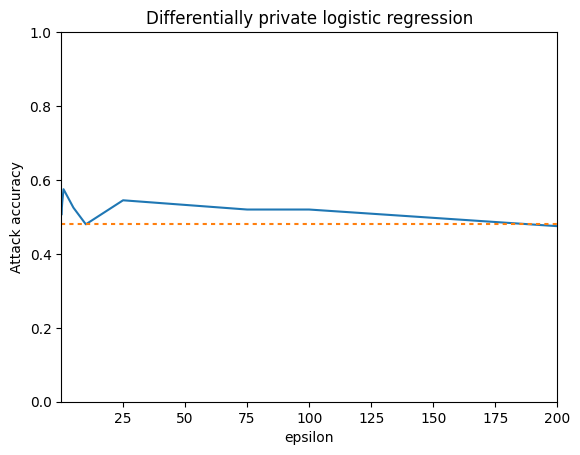

In [ ]:
plt.plot(epsilons, attack_accuracy)
plt.plot(epsilons, np.ones_like(epsilons) * acc, dashes=[2,2], label="base model")
plt.title("Differentially private logistic regression")
plt.xlabel("epsilon")
plt.ylabel("Attack accuracy")
plt.ylim(0, 1)
plt.xlim(0.1, 200)
plt.show()

Looks like epsilon=25 is a good choice.

In [ ]:
dp_model = dp.LogisticRegression(epsilon=25, data_norm=5)
dp_model.fit(x_train, y_train)

dp_art_classifier = ScikitlearnLogisticRegression(dp_model)
print('DP model accuracy with eps=100: ', dp_model.score(x_test, y_test))

dp_attack = MembershipInferenceBlackBox(dp_art_classifier, attack_model_type='rf')
dp_attack.fit(x_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size].astype(np.float32),
              x_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
dp_inferred_train = dp_attack.infer(x_train.astype(np.float32)[attack_train_size:], y_train.astype(np.float32)[attack_train_size:])
dp_inferred_test = dp_attack.infer(x_test.astype(np.float32)[attack_test_size:], y_test.astype(np.float32)[attack_test_size:])
dp_train_acc = np.sum(dp_inferred_train) / len(dp_inferred_train)
dp_test_acc = 1 - (np.sum(dp_inferred_test) / len(dp_inferred_test))
dp_acc = (dp_train_acc * len(dp_inferred_train) + dp_test_acc * len(dp_inferred_test)) / (len(dp_inferred_train) + len(dp_inferred_test))

print('DP model attack accuracy with eps=100: ', dp_acc)

DP model accuracy with eps=100:  0.32
DP model attack accuracy with eps=100:  0.525


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
